In [424]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sysidentpy.basis_function._basis_function import Polynomial 
from sysidentpy.utils.display_results import results 
from scipy.optimize import curve_fit
import control as ctl

In [425]:
df = pd.read_csv('DataBase.csv')
N  = df.shape[0]

print('N:', N)
df.head()

N: 2304


,input,output,time
0,255,1008,2.160
1,255,821,2.175
2,255,699,2.190
3,255,495,2.250
4,255,472,2.265


In [426]:
def getUniformDataframe(df, size):
    indices = np.linspace(0, len(df) - 1, size, dtype=int)
    return df.iloc[indices]

#df = getUniformDataframe(df, 1000)
N  = df.shape[0]

print('N:', N)
df.head()

N: 2304


,input,output,time
0,255,1008,2.160
1,255,821,2.175
2,255,699,2.190
3,255,495,2.250
4,255,472,2.265


In [427]:
def normalizeData(df, key, dt):
    sumTime = 0

    for i, val in df.iterrows():
        sumTime += dt
        val[key] = sumTime
        df.iloc[i] = val
        
    return df


df = normalizeData(df, 'time', 0.015)
df

,input,output,time
0,255,1008,0.015
1,255,821,0.030
2,255,699,0.045
3,255,495,0.060
4,255,472,0.075
...,...,...,...
2299,122,509,34.500
2300,122,456,34.515
2301,122,481,34.530
2302,122,467,34.545


In [428]:
#df['output'] = df.output - df.output.mean()

# FILTRAGEM DOS DADOS

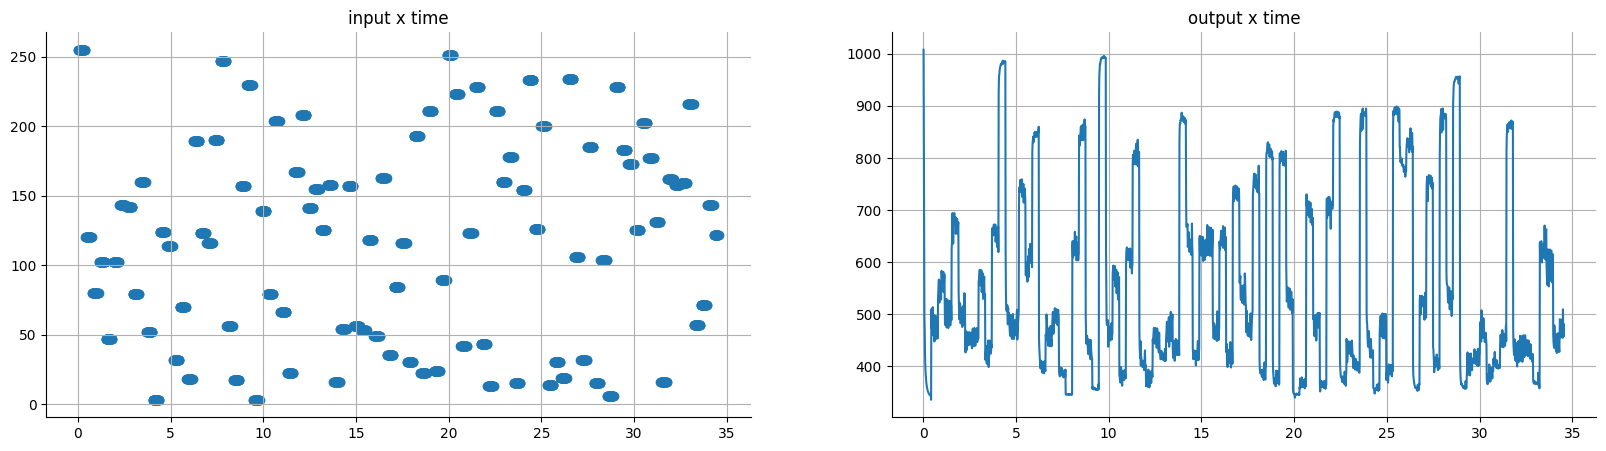

In [429]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.scatter(df.time, df.input)
plt.title('input x time')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(df.time, df.output)
plt.title('output x time')
plt.grid()

# TREINO E TESTE

In [430]:
stop = N // 2
print('stop: ', stop)

xTrain, yTrain = df[['input']][:stop], df['output'][:stop]
xTest, yTest   = df[['input']][stop:], df['output'][stop:]

xTrain = xTrain.values.reshape(-1, 1)
xTest  = xTest.values.reshape(-1, 1)
yTrain = yTrain.values.reshape(-1, 1)
yTest  = yTest.values.reshape(-1, 1)

stop:  1152


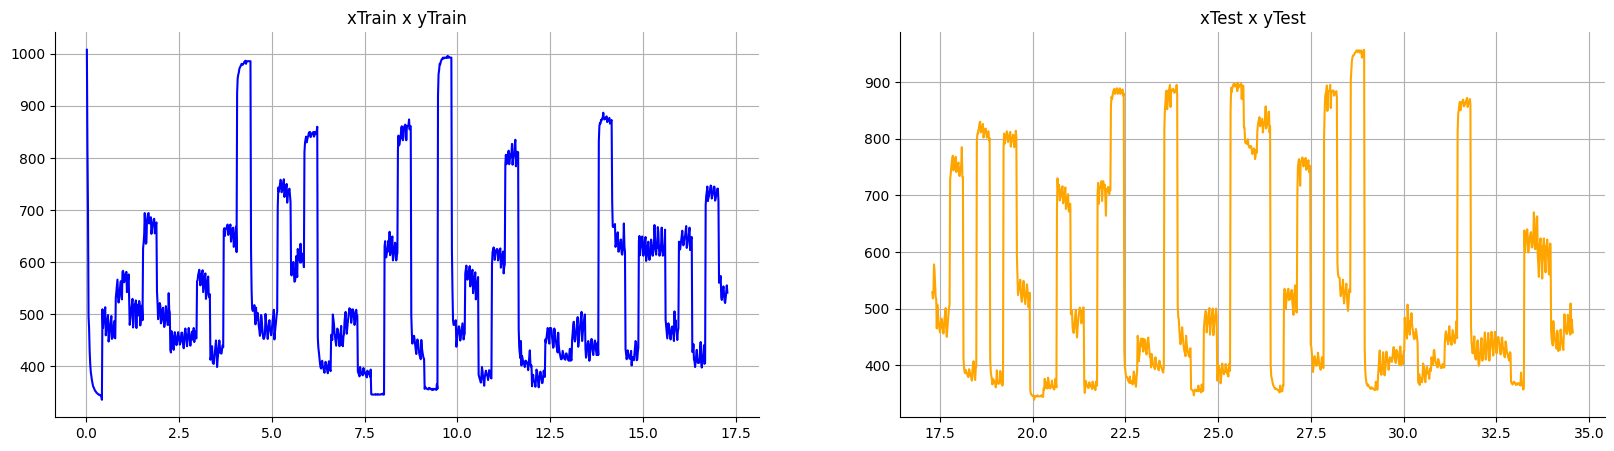

In [431]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(df.time[:stop], df.output[:stop], color='blue')
plt.title('xTrain x yTrain')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(df.time[stop:], df.output[stop:], color='orange')
plt.title('xTest x yTest')
plt.grid()

# MÉTODO FROLS

In [432]:
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.metrics import root_relative_squared_error 

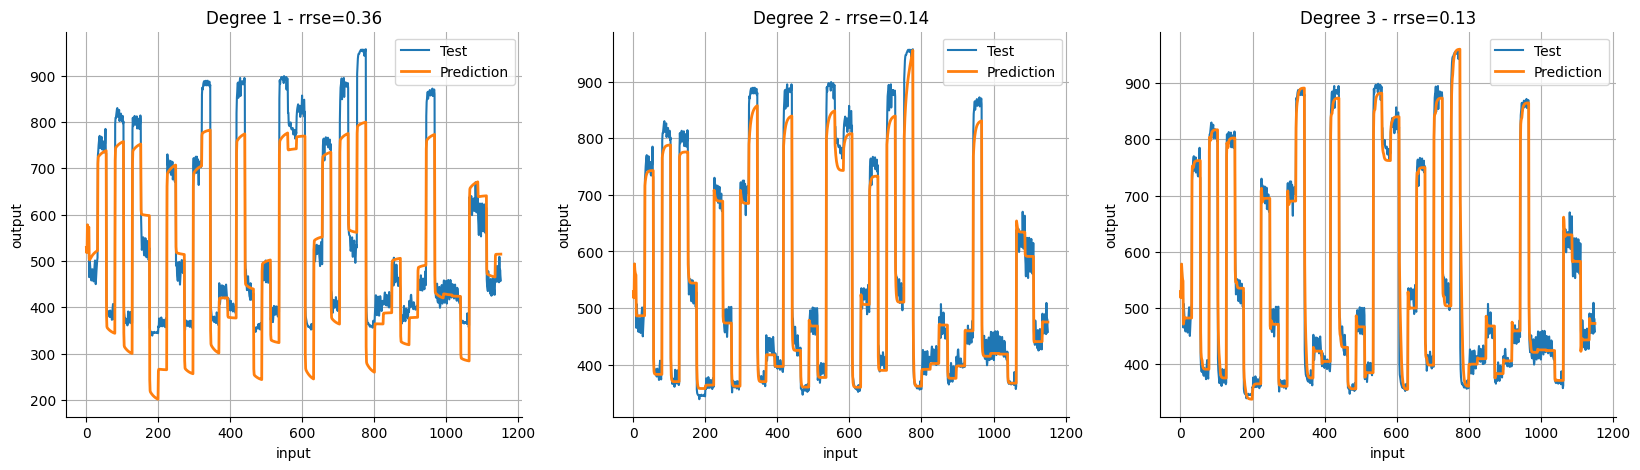

In [433]:
plt.figure(figsize=(20, 5))

def plotModel(degree):
    model = FROLS(
        order_selection=True,
        n_info_values=10,
        extended_least_squares=False,
        ylag=5,
        xlag=5,
        info_criteria='aic',
        estimator='least_squares',
        basis_function=Polynomial(degree=degree)
    )

    model.fit(X=xTrain, y=yTrain)
    yModel = model.predict(X=xTest, y=yTest)
    rrse = root_relative_squared_error(yTest, yModel)

    plt.subplot(1, 3, degree)
    plt.plot(yTest, label='Test')
    plt.plot(yModel, label='Prediction', linewidth=2)
    plt.title(f'Degree {degree} - rrse={round(rrse, 2)}')
    plt.xlabel('input')
    plt.ylabel('output')
    plt.legend()
    plt.grid()

plotModel(1)
plotModel(2)
plotModel(3)

c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 3 
  self.info_values = self.information_criterion(reg_matrix, y)
c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors space considering the chosen y_lag, u_lag, and non_degree. We set as 5 
  self.info_values = self.information_criterion(reg_matrix, y)
c:\Users\march\AppData\Local\Programs\Python\Python312\Lib\site-packages\sysidentpy\model_structure_selection\forward_regression_orthogonal_least_squares.py:481: UserWarning: n_info_values is greater than the maximum number of all regressors spac

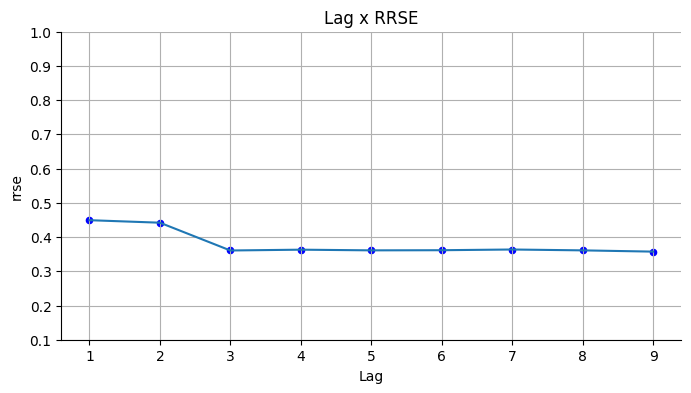

In [434]:
models = []
N_INFO_VALUES = 100
rangeLimits = range(1, 10)

for i in rangeLimits:
    model = FROLS(
        order_selection=True,
        n_info_values=N_INFO_VALUES,
        extended_least_squares=False,
        ylag=i,
        xlag=i,
        info_criteria='aic',
        estimator='least_squares',
        basis_function=Polynomial(degree=1)
    )

    model.fit(X=xTrain, y=yTrain)
    yModel = model.predict(X=xTest, y=yTest)
    rrse = root_relative_squared_error(yTest, yModel)
    models.append({'lag': i, 'model': model, 'yModel': yModel, 'rrse': rrse})


plt.figure(figsize=(8, 4))
plt.plot([model['lag'] for model in models], [model['rrse'] for model in models])
plt.scatter([model['lag'] for model in models], [model['rrse'] for model in models], color='blue', s=20)
plt.xticks([i for i in rangeLimits])
plt.yticks(np.arange(0.1, 1.1, .1))
plt.xlabel('Lag')
plt.ylabel('rrse')
plt.title('Lag x RRSE')
plt.grid()

In [435]:
bestModel = models[2]
model  = bestModel['model']
yModel = bestModel['yModel']

print('lag: ', bestModel['lag'], '| rrse: ', bestModel['rrse'])

lag:  3 | rrse:  0.36074033821229895


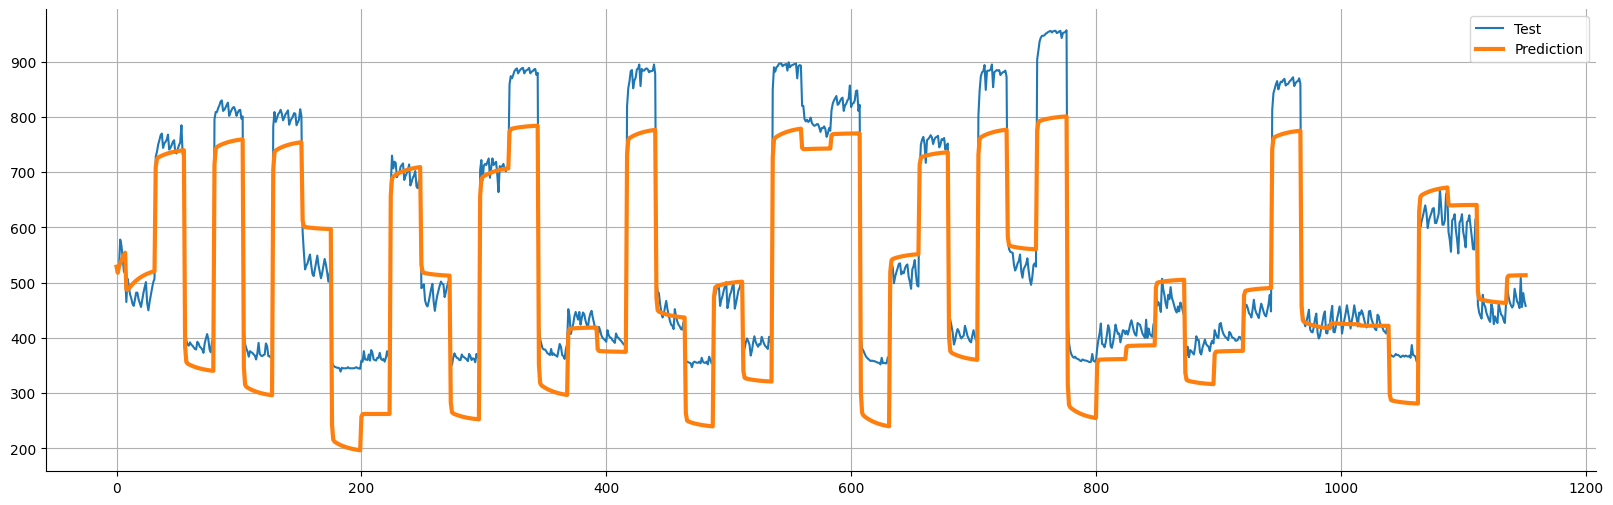

In [436]:
plt.figure(figsize=(20, 6))

plt.plot(yTest, label='Test')
plt.plot(yModel, label='Prediction', linewidth=3)
plt.legend()
plt.grid()

In [437]:
resultsData = results(model.final_model, model.theta, model.err, model.n_terms, err_precision=8, dtype="sci")
resultsData = pd.DataFrame(resultsData, columns=['indice', 'theta', 'prec'])

resultsData['theta'] = pd.to_numeric(resultsData.theta, errors='coerce')
resultsData

,indice,theta,prec
0,y(k-1),0.99964,9.93572238E-01
1,1,55.16100,1.17033303E-04
2,x1(k-2),-2.18670,1.93663475E-03
3,x1(k-3),2.01870,2.97076734E-03
4,y(k-2),-0.06708,2.50409159E-05


In [438]:
def getTheta(indice):
    target = resultsData.loc[resultsData.indice == indice]
    return 0 if len(target) == 0 else float(target.iloc[0].theta)


numerator = [
    getTheta('1'),
    getTheta('x1(k-1)'),
    getTheta('x1(k-2)'),
    getTheta('x1(k-3)'),
]

denominator = [
    1,
    -getTheta('y(k-1)'),
    -getTheta('y(k-2)'),
    -getTheta('y(k-3)'),
]

print('numerator:   ', numerator)
print('denominator: ', denominator)

G = ctl.TransferFunction(numerator, denominator, 0.015)
G

numerator:    [55.161, 0, -2.1867, 2.0187]
denominator:  [1, -0.99964, 0.06708, 0]


TransferFunction(array([55.161 ,  0.    , -2.1867,  2.0187]), array([ 1.     , -0.99964,  0.06708,  0.     ]), 0.015)

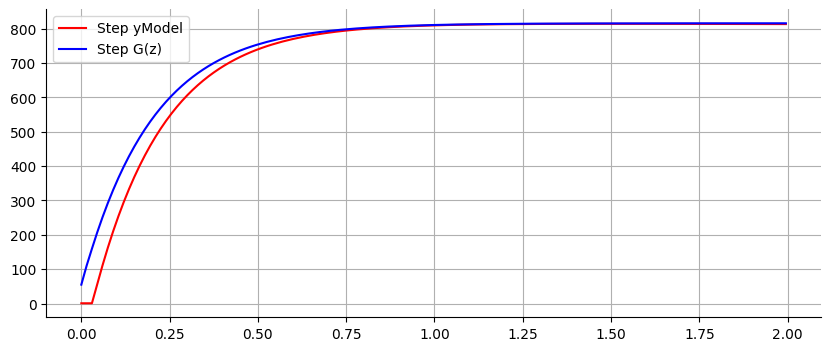

In [439]:
tData = np.arange(0, 2, 0.015)
uData = np.ones(len(tData))

yModel = model.predict(X=tData.reshape(-1, 1), y=uData.reshape(-1, 1))
time, response = ctl.forced_response(G, T=tData, U=uData)

plt.figure(figsize=(10, 4))
plt.plot(time, yModel, color='red', label='Step yModel')
plt.plot(time, response, color='blue', label='Step G(z)')
plt.grid()
plt.legend()

In [440]:
tData = df.time.values 
uData = df.input.values
time, response = ctl.forced_response(G, T=tData, U=uData)

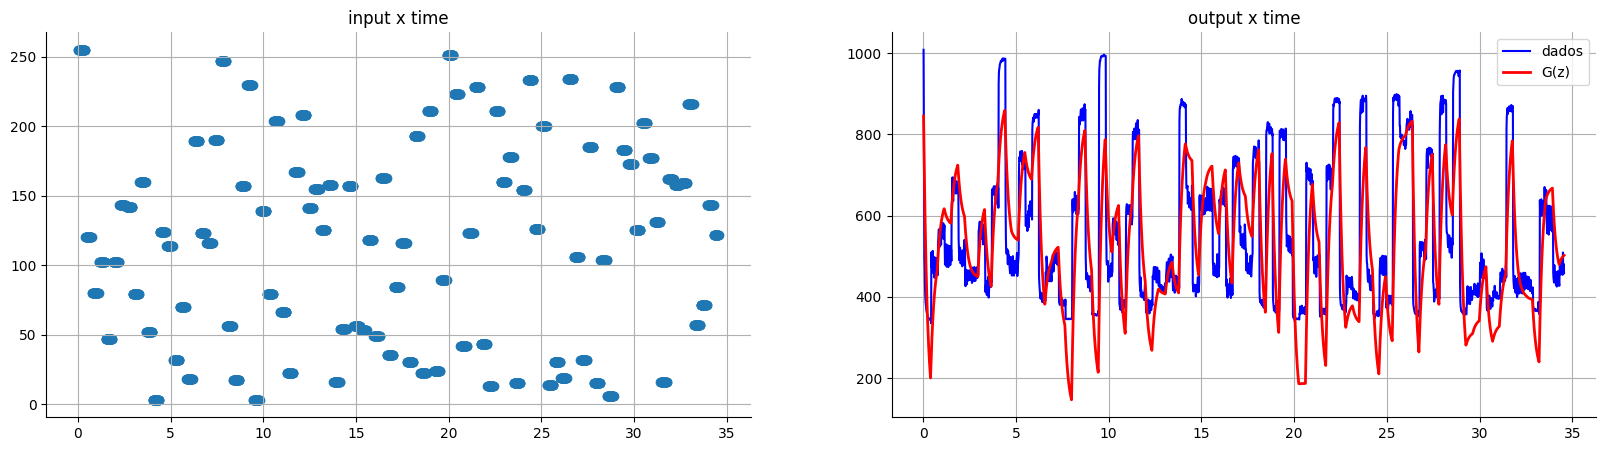

In [441]:
plt.figure(figsize=(20, 5))
aux = response / -255 + 900

plt.subplot(1, 2, 1)
plt.scatter(df.time, df.input)
plt.title('input x time')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(df.time, df.output, label='dados', color='blue')
plt.plot(time, aux, label='G(z)', color='red', linewidth=2)
plt.title('output x time')
plt.grid()
plt.legend()

# INFORMAÇÕES DA TF

polos:  (0.927+0j) (0.072+0j) 0j
zeros:  (-0.372+0j) (0.186+0.253j) (0.186-0.253j)


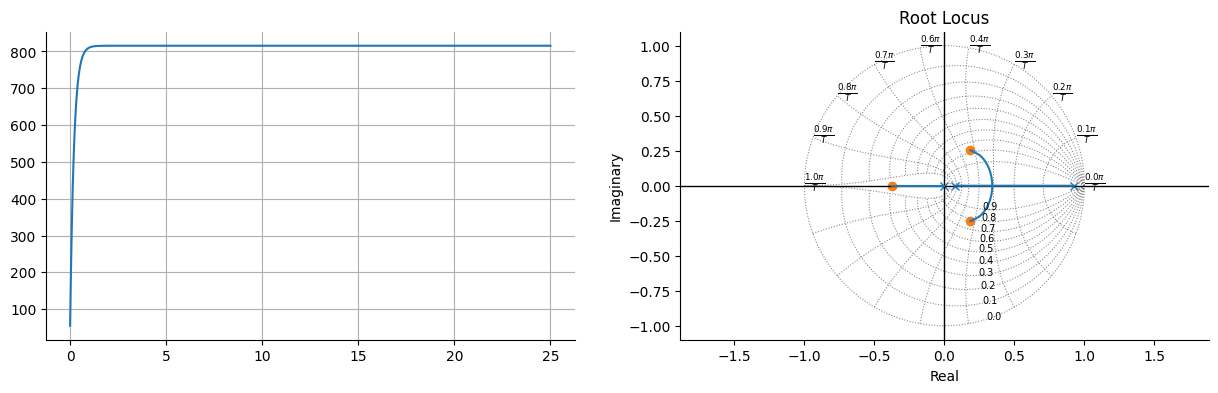

In [442]:
poles = ctl.poles(G)
zeros = ctl.zeros(G)
print('polos: ', *[np.round(pole, 3) for pole in poles])
print('zeros: ', *[np.round(zero, 3) for zero in zeros])

time, response = ctl.step_response(G)
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
plt.plot(time, response)
plt.grid()

plt.subplot(1, 2, 2)
ctl.root_locus(G)
plt.show()

In [443]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, show=False)

{'overshoot': 0.0,
 'peakValue': 815.4359430604973,
 'peakTime': 6.8999999999999995,
 'settlingTime': 0.765,
 'finalValue': 815.4359430604973,
 'error': 814.4359430604973}

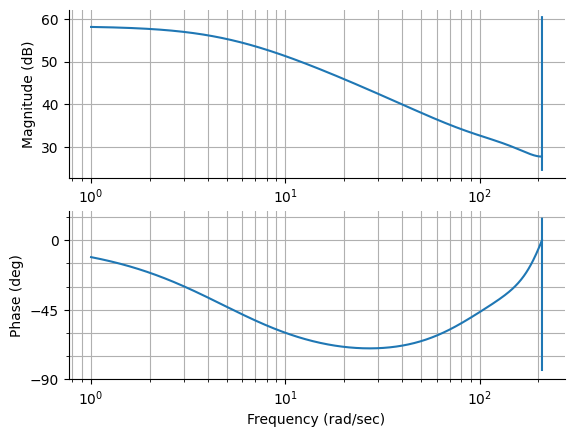

In [444]:
mag, phase, omega = ctl.bode_plot(G, dB=True)

Text(0.5, 1.0, 'Diagrama de Nyquist')

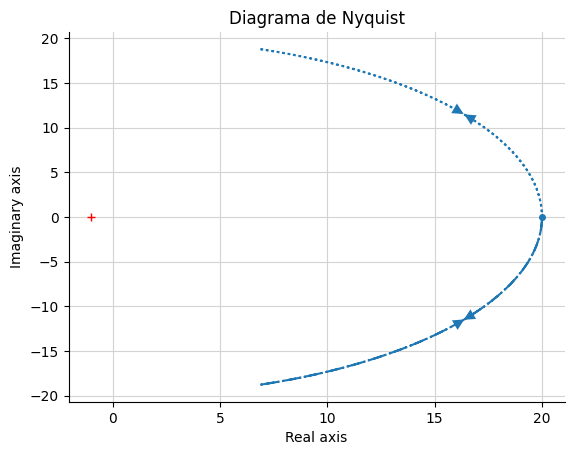

In [445]:
ctl.nyquist(G)
plt.title('Diagrama de Nyquist')

# NARX Neural Network

In [446]:
from sysidentpy.neural_network import NARXNN
from sysidentpy.basis_function import Polynomial
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation
from sysidentpy.residues.residues_correlation import compute_cross_correlation
from torch import nn

class NARX(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(4, 10)
        self.lin2 = nn.Linear(10, 10)
        self.lin3 = nn.Linear(10, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z


model = NARXNN(
    net=NARX(),
    ylag=2,
    xlag=2,
    basis_function=Polynomial(degree=1),
    model_type="NARMAX",
    loss_func='mse_loss',
    optimizer='Adam',
    epochs=200,
    verbose=False,
    optim_params={'betas': (0.9, 0.999), 'eps': 1e-05}
)

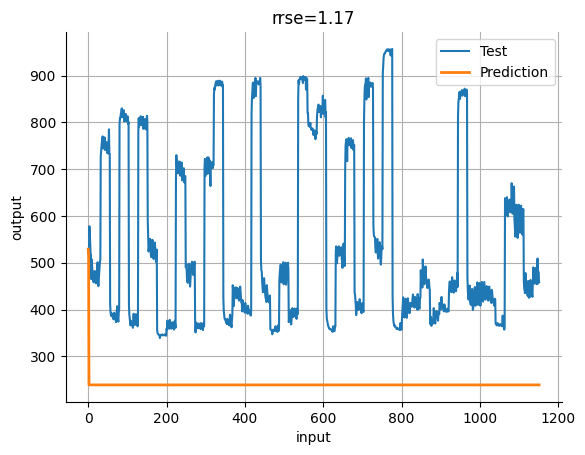

In [447]:
model.fit(X=xTrain, y=yTrain)
yModel = model.predict(X=xTest, y=yTest)
rrse = root_relative_squared_error(yTest, yModel)

plt.plot(yTest, label='Test')
plt.plot(yModel, label='Prediction', linewidth=2)
plt.title(f'rrse={round(rrse, 2)}')
plt.xlabel('input')
plt.ylabel('output')
plt.legend()
plt.grid()

# CATBOOST-NARX

In [448]:
from catboost import CatBoostRegressor
from sysidentpy.general_estimators import NARX
from sysidentpy.basis_function import Polynomial
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation
from sysidentpy.residues.residues_correlation import compute_cross_correlation


model = NARX(
    base_estimator=CatBoostRegressor(
        iterations=300,
        learning_rate=0.1,
        depth=6),
    xlag=2,
    ylag=2,
    basis_function=Polynomial(degree=1),
    fit_params={'verbose': False}
)

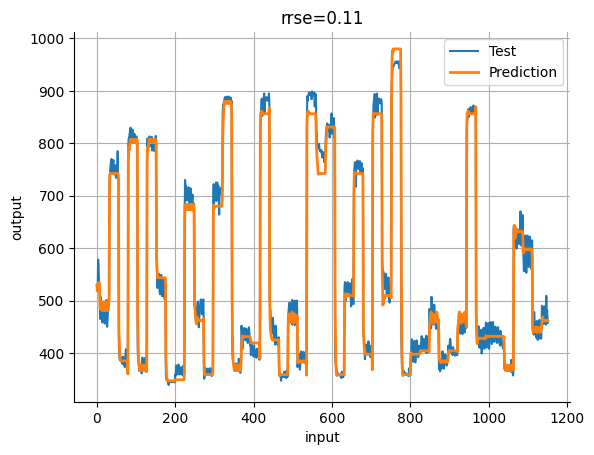

In [449]:
model.fit(X=xTrain, y=yTrain)
yModel = model.predict(X=xTest, y=yTest)
rrse = root_relative_squared_error(yTest, yModel)

plt.plot(yTest, label='Test')
plt.plot(yModel, label='Prediction', linewidth=2)
plt.title(f'rrse={round(rrse, 2)}')
plt.xlabel('input')
plt.ylabel('output')
plt.legend()
plt.grid()

# Catboost without NARX configuration

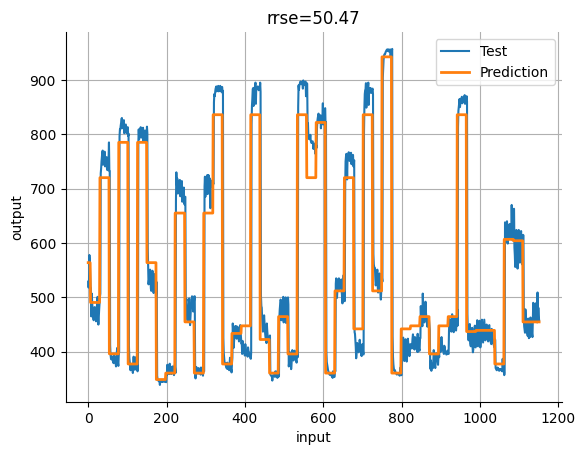

In [450]:
model = CatBoostRegressor(
    iterations=300,
    learning_rate=0.1,
    depth=6
)

model.fit(xTrain, yTrain, verbose=False)
yModel = model.predict(xTest)
rrse = root_relative_squared_error(yTest, yModel)

plt.plot(yTest, label='Test')
plt.plot(yModel, label='Prediction', linewidth=2)
plt.title(f'rrse={round(rrse, 2)}')
plt.xlabel('input')
plt.ylabel('output')
plt.legend()
plt.grid()

# CONTROLLER

In [451]:
import sympy as sp

def plotStep(time, response, sp=1):
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 2, 1)
    plt.title('Step Response')
    plt.plot(time, response)
    plt.plot(time, [sp for i in time], '--')
    plt.xlabel('time')
    plt.ylabel('response')
    plt.grid()

    plt.subplot(1, 2, 2)
    ctl.root_locus(G)
    plt.show()

def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    z = sp.var('z')
    num_expr = sum(coef*z**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*z**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=6):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

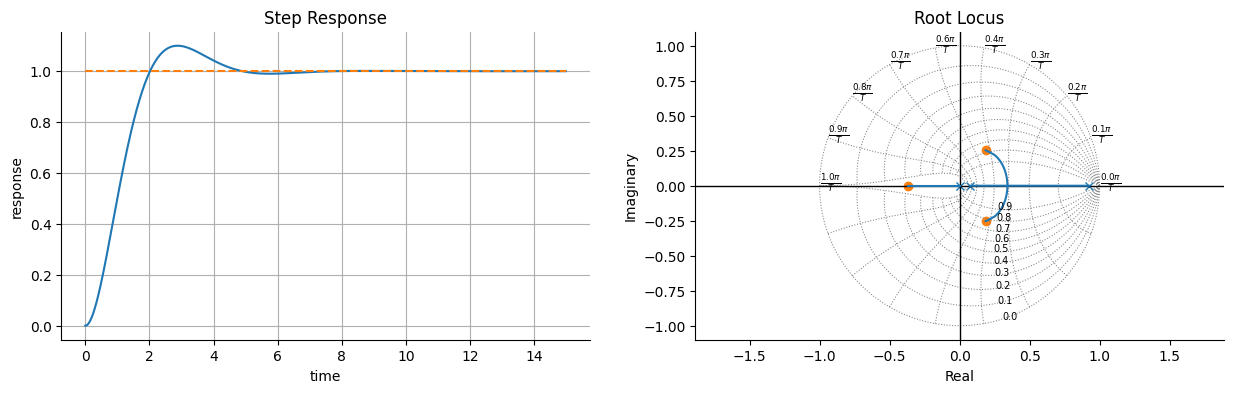

In [452]:
Ts = 5
UP = 0.1

zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
Wn = 4/(zeta*Ts)

s = ctl.TransferFunction.s
T = np.arange(0, Ts*3, 0.015)

tData, desired = ctl.step_response(Wn**2/(s**2 + 2*zeta*Wn*s + Wn**2), T=T)
plotStep(tData, desired)

In [453]:
z = ctl.TransferFunction.z
G_c = (z**2 + 2)/(2*z)
G_c

TransferFunction(array([1, 0, 2]), array([2, 0]), True)

In [454]:
def C(z, a, b, c, d, e):
    z = ctl.TransferFunction.z
    G_c = (a*z**2 + b*z + c)/(z**2 + d*z + e)
    
    G_feedback = ctl.feedback(G*G_c, 1)
    return ctl.step_response(G_feedback, T=tData)[1] # response

def getFunction(xDados, yDados):
    coeficientes = curve_fit(C, xDados, yDados, maxfev=1000000000)  # MÁXIMO DE ITERAÇÕES
    return list(coeficientes[0])

In [455]:
coefs = getFunction(tData, desired)  
coefs

[-2.496046614361036e-06,
 1.166265200268582e-05,
 -8.667205108409303e-06,
 -1.9760773190268117,
 0.9760773187133103]

In [456]:
a, b, c, d, e = coefs
C = (a*z**2 + b*z + c)/(z**2 + d*z + e)
C

TransferFunction(array([-2.49604661e-06,  1.16626520e-05, -8.66720511e-06]), array([ 1.        , -1.97607732,  0.97607732]), True)

In [458]:
G_feedback = ctl.feedback(G*C, 1)
G_feedback

TransferFunction(array([-1.37684427e-04,  6.43323547e-04, -4.72633596e-04, -3.05414904e-05,
        4.24959730e-05, -1.74964870e-05]), array([ 9.99862316e-01, -2.97507400e+00,  3.01805062e+00, -1.10831174e+00,
        6.55177625e-02, -1.74964870e-05]), 0.015)

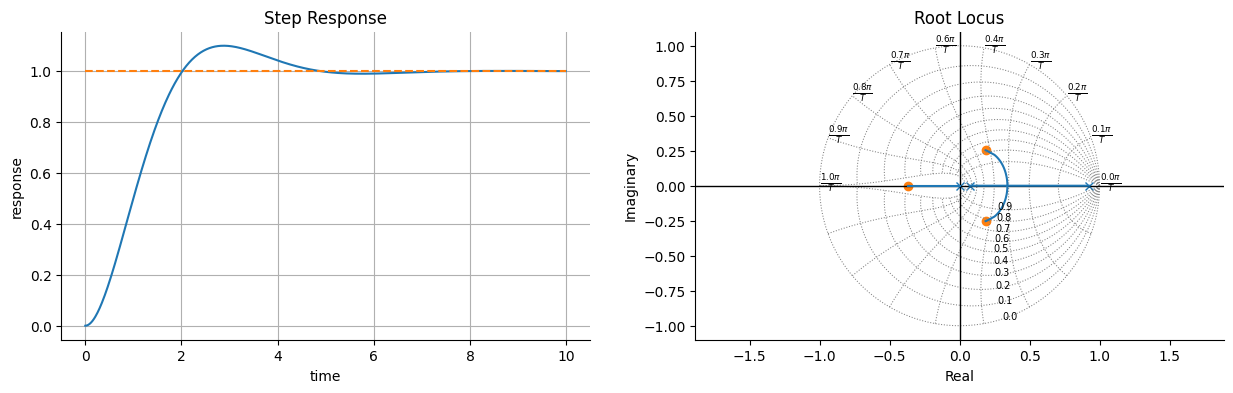

In [459]:
tData = np.arange(0, Ts*2, 0.015)
time, response = ctl.step_response(G_feedback, T=tData)

plotStep(time, response)

In [460]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, show=False)

{'overshoot': 0.09969591561860419,
 'peakValue': 1.100001980264864,
 'peakTime': 2.88,
 'settlingTime': 4.38,
 'finalValue': 1.0002783175257022,
 'error': 0.0002783175257021764}